In [2]:
import pandas as pd
import numpy as np 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, log_loss
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
import category_encoders as ce
from numpy.testing import assert_almost_equal
from functools import reduce
import matplotlib.pyplot as plt
import time
from category_encoders.binary import BinaryEncoder
pd.set_option('display.max_columns', None)  # Unlimited columns
import xgboost as xgb

In [3]:
url = "unit-3/train_features.csv"
df = pd.read_csv(url, parse_dates=['date_recorded'],index_col='id' )

In [4]:
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
df.shape

(59400, 39)

In [6]:
yurl = 'unit-3/train_labels.csv'
dfy = pd.read_csv(yurl, index_col='id' )

In [7]:
dfum = df.merge(dfy, left_index=True, right_index=True)

In [8]:
dfum.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [9]:
dc = 'status_group'

In [10]:
oc = dfum.select_dtypes(include=['object']).columns
oc = oc.drop(dc)
oc

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [11]:
hot = []
binary = []
for o in oc:
    if dfum[o].unique().shape[0] > 10:
        binary.append(o)
    else:
        hot.append(o)

In [12]:
encoders = Pipeline([
                ('binary', BinaryEncoder(cols=binary)),
                ('onehot', ce.OneHotEncoder(use_cat_names=True,cols=hot))
            ])
df_ = encoders.fit_transform(dfum)

In [13]:
de = df_.describe()
ex_oc = df_.columns
drop = []
for o in ex_oc:
    if o in de.columns:
        if de[o]['mean'] == 0:
            drop.append(o)
        # print(de[o].mean)
dfd_ = df_.drop(drop, axis=1)
print(drop)

['basin_-1', 'public_meeting_-1', 'recorded_by_-1', 'permit_-1', 'extraction_type_class_-1', 'management_group_-1', 'payment_-1', 'payment_type_-1', 'water_quality_-1', 'quality_group_-1', 'quantity_-1', 'quantity_group_-1', 'source_-1', 'source_type_-1', 'source_class_-1', 'waterpoint_type_-1', 'waterpoint_type_group_-1', 'funder_0', 'installer_0', 'wpt_name_0', 'subvillage_0', 'region_0', 'lga_0', 'ward_0', 'scheme_management_0', 'scheme_name_0', 'extraction_type_0', 'extraction_type_group_0', 'management_0']


In [14]:
dfd_.describe()

,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,public_meeting_True,public_meeting_nan,public_meeting_False,recorded_by_GeoData Consultants Ltd,permit_False,permit_True,permit_nan,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown,payment_pay annually,payment_never pay,payment_pay per bucket,payment_unknown,payment_pay when scheme fails,payment_other,payment_pay monthly,payment_type_annually,payment_type_never pay,payment_type_per bucket,payment_type_unknown,payment_type_on failure,payment_type_other,payment_type_monthly,water_quality_soft,water_quality_salty,water_quality_milky,water_quality_unknown,water_quality_fluoride,water_quality_coloured,water_quality_salty abandoned,water_quality_fluoride abandoned,quality_group_good,quality_group_salty,quality_group_milky,quality_group_unknown,quality_group_fluoride,quality_group_colored,quantity_enough,quantity_insufficient,quantity_dry,quantity_seasonal,quantity_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_dry,quantity_group_seasonal,quantity_group_unknown,source_spring,source_rainwater harvesting,source_dam,source_machine dbh,source_other,source_shallow well,source_river,source_hand dtw,source_lake,source_unknown,source_type_spring,source_type_rainwater harvesting,source_type_dam,source_type_borehole,source_type_other,source_type_shallow well,source_type_river/lake,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other,waterpoint_type_improved spring,waterpoint_type_cattle trough,waterpoint_type_dam,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_other,waterpoint_type_group_improved spring,waterpoint_type_group_cattle trough,waterpoint_type_group_dam,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,funder_10,funder_11,installer_1,installer_2,installer_3,installer_4,installer_5,installer_6,installer_7,installer_8,installer_9,installer_10,installer_11,installer_12,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,wpt_name_5,wpt_name_6,wpt_name_7,wpt_name_8,wpt_name_9,wpt_name_10,wpt_name_11,wpt_name_12,wpt_name_13,wpt_name_14,wpt_name_15,wpt_name_16,subvillage_1,subvillage_2,subvillage_3,subvillage_4,subvillage_5,subvillage_6,subvillage_7,subvillage_8,subvillage_9,subvillage_10,subvillage_11,subvillage_12,subvillage_13,subvillage_14,subvillage_15,region_1,region_2,region_3,region_4,region_5,lga_1,lga_2,lga_3,lga_4,lga_5,lga_6,lga_7,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8,ward_9,ward_10,ward_11,ward_12,scheme_management_1,scheme_management_2,scheme_management_3,scheme_management_4,scheme_name_1,scheme_name_2,scheme_name_3,scheme_name_4,scheme_name_5,scheme_name_6,scheme_name_7,scheme_name_8,scheme_name_9,scheme_name_10,scheme_name_11,scheme_name_12,extraction_type_1,extraction_type_2,extraction_type_3,extraction_type_4,extraction_type_5,extraction_type_group_1,extraction_type_group_2,extraction_type_group_3,extraction_type_group_4,management_1,management_2,management_3,management_4,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.0,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.00000

In [15]:
dfd_.head()

,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,public_meeting_True,public_meeting_nan,public_meeting_False,recorded_by_GeoData Consultants Ltd,permit_False,permit_True,permit_nan,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown,payment_pay annually,payment_never pay,payment_pay per bucket,payment_unknown,payment_pay when scheme fails,payment_other,payment_pay monthly,payment_type_annually,payment_type_never pay,payment_type_per bucket,payment_type_unknown,payment_type_on failure,payment_type_other,payment_type_monthly,water_quality_soft,water_quality_salty,water_quality_milky,water_quality_unknown,water_quality_fluoride,water_quality_coloured,water_quality_salty abandoned,water_quality_fluoride abandoned,quality_group_good,quality_group_salty,quality_group_milky,quality_group_unknown,quality_group_fluoride,quality_group_colored,quantity_enough,quantity_insufficient,quantity_dry,quantity_seasonal,quantity_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_dry,quantity_group_seasonal,quantity_group_unknown,source_spring,source_rainwater harvesting,source_dam,source_machine dbh,source_other,source_shallow well,source_river,source_hand dtw,source_lake,source_unknown,source_type_spring,source_type_rainwater harvesting,source_type_dam,source_type_borehole,source_type_other,source_type_shallow well,source_type_river/lake,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other,waterpoint_type_improved spring,waterpoint_type_cattle trough,waterpoint_type_dam,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_other,waterpoint_type_group_improved spring,waterpoint_type_group_cattle trough,waterpoint_type_group_dam,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,funder_10,funder_11,installer_1,installer_2,installer_3,installer_4,installer_5,installer_6,installer_7,installer_8,installer_9,installer_10,installer_11,installer_12,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,wpt_name_5,wpt_name_6,wpt_name_7,wpt_name_8,wpt_name_9,wpt_name_10,wpt_name_11,wpt_name_12,wpt_name_13,wpt_name_14,wpt_name_15,wpt_name_16,subvillage_1,subvillage_2,subvillage_3,subvillage_4,subvillage_5,subvillage_6,subvillage_7,subvillage_8,subvillage_9,subvillage_10,subvillage_11,subvillage_12,subvillage_13,subvillage_14,subvillage_15,region_1,region_2,region_3,region_4,region_5,lga_1,lga_2,lga_3,lga_4,lga_5,lga_6,lga_7,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8,ward_9,ward_10,ward_11,ward_12,scheme_management_1,scheme_management_2,scheme_management_3,scheme_management_4,scheme_name_1,scheme_name_2,scheme_name_3,scheme_name_4,scheme_name_5,scheme_name_6,scheme_name_7,scheme_name_8,scheme_name_9,scheme_name_10,scheme_name_11,scheme_name_12,extraction_type_1,extraction_type_2,extraction_type_3,extraction_type_4,extraction_type_5,extraction_type_group_1,extraction_type_group_2,extraction_type_group_3,extraction_type_group_4,management_1,management_2,management_3,management_4,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,

In [16]:
dfd_['timestamp'] = dfd_.date_recorded.apply(lambda d: d.timestamp()/ 10 ** 9)
dfdd = dfd_.drop('date_recorded', inplace = False, axis=1)
dfdd.head()

,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,public_meeting_True,public_meeting_nan,public_meeting_False,recorded_by_GeoData Consultants Ltd,permit_False,permit_True,permit_nan,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown,payment_pay annually,payment_never pay,payment_pay per bucket,payment_unknown,payment_pay when scheme fails,payment_other,payment_pay monthly,payment_type_annually,payment_type_never pay,payment_type_per bucket,payment_type_unknown,payment_type_on failure,payment_type_other,payment_type_monthly,water_quality_soft,water_quality_salty,water_quality_milky,water_quality_unknown,water_quality_fluoride,water_quality_coloured,water_quality_salty abandoned,water_quality_fluoride abandoned,quality_group_good,quality_group_salty,quality_group_milky,quality_group_unknown,quality_group_fluoride,quality_group_colored,quantity_enough,quantity_insufficient,quantity_dry,quantity_seasonal,quantity_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_dry,quantity_group_seasonal,quantity_group_unknown,source_spring,source_rainwater harvesting,source_dam,source_machine dbh,source_other,source_shallow well,source_river,source_hand dtw,source_lake,source_unknown,source_type_spring,source_type_rainwater harvesting,source_type_dam,source_type_borehole,source_type_other,source_type_shallow well,source_type_river/lake,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other,waterpoint_type_improved spring,waterpoint_type_cattle trough,waterpoint_type_dam,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_other,waterpoint_type_group_improved spring,waterpoint_type_group_cattle trough,waterpoint_type_group_dam,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,funder_10,funder_11,installer_1,installer_2,installer_3,installer_4,installer_5,installer_6,installer_7,installer_8,installer_9,installer_10,installer_11,installer_12,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,wpt_name_5,wpt_name_6,wpt_name_7,wpt_name_8,wpt_name_9,wpt_name_10,wpt_name_11,wpt_name_12,wpt_name_13,wpt_name_14,wpt_name_15,wpt_name_16,subvillage_1,subvillage_2,subvillage_3,subvillage_4,subvillage_5,subvillage_6,subvillage_7,subvillage_8,subvillage_9,subvillage_10,subvillage_11,subvillage_12,subvillage_13,subvillage_14,subvillage_15,region_1,region_2,region_3,region_4,region_5,lga_1,lga_2,lga_3,lga_4,lga_5,lga_6,lga_7,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8,ward_9,ward_10,ward_11,ward_12,scheme_management_1,scheme_management_2,scheme_management_3,scheme_management_4,scheme_name_1,scheme_name_2,scheme_name_3,scheme_name_4,scheme_name_5,scheme_name_6,scheme_name_7,scheme_name_8,scheme_name_9,scheme_name_10,scheme_name_11,scheme_name_12,extraction_type_1,extraction_type_2,extraction_type_3,extraction_type_4,extraction_type_5,extraction_type_group_1,extraction_type_group_2,extraction_type_group_3,extraction_type_group_4,management_1,management_2,management_3,management_4,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group,timestamp
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,

In [17]:
df_sample = pd.read_csv('unit-3/sample_submission.csv', index_col='id')
df_sample.head()

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,functional
49871,functional


In [18]:
short = dfdd.sample(frac=0.03, axis=0, random_state=42)
short.shape


(1782, 217)

In [19]:
len(short.dtypes)

217

In [20]:
X = short.drop(dc, axis=1)
y = short[dc]
X.shape, y.shape

((1782, 216), (1782,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [22]:
continuous_features = dfdd.drop(dc, axis=1).select_dtypes(include='float').columns
discrete_features = dfdd.drop(dc, axis=1).select_dtypes(include='int').columns
# print(continuous_features)
# print(discrete_features)
assert_almost_equal(len(continuous_features) + len(discrete_features) + 1, dfdd.dtypes.value_counts().sum())

# take the #observations ought to be > 5 * #features heuristic

a = 6
b = 2
NCm = int(np.divide(len(df_.columns), a))

ints_df = dfdd[discrete_features]

ints_df.describe()

,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,public_meeting_True,public_meeting_nan,public_meeting_False,recorded_by_GeoData Consultants Ltd,permit_False,permit_True,permit_nan,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown,payment_pay annually,payment_never pay,payment_pay per bucket,payment_unknown,payment_pay when scheme fails,payment_other,payment_pay monthly,payment_type_annually,payment_type_never pay,payment_type_per bucket,payment_type_unknown,payment_type_on failure,payment_type_other,payment_type_monthly,water_quality_soft,water_quality_salty,water_quality_milky,water_quality_unknown,water_quality_fluoride,water_quality_coloured,water_quality_salty abandoned,water_quality_fluoride abandoned,quality_group_good,quality_group_salty,quality_group_milky,quality_group_unknown,quality_group_fluoride,quality_group_colored,quantity_enough,quantity_insufficient,quantity_dry,quantity_seasonal,quantity_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_dry,quantity_group_seasonal,quantity_group_unknown,source_spring,source_rainwater harvesting,source_dam,source_machine dbh,source_other,source_shallow well,source_river,source_hand dtw,source_lake,source_unknown,source_type_spring,source_type_rainwater harvesting,source_type_dam,source_type_borehole,source_type_other,source_type_shallow well,source_type_river/lake,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other,waterpoint_type_improved spring,waterpoint_type_cattle trough,waterpoint_type_dam,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_other,waterpoint_type_group_improved spring,waterpoint_type_group_cattle trough,waterpoint_type_group_dam,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,funder_10,funder_11,installer_1,installer_2,installer_3,installer_4,installer_5,installer_6,installer_7,installer_8,installer_9,installer_10,installer_11,installer_12,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,wpt_name_5,wpt_name_6,wpt_name_7,wpt_name_8,wpt_name_9,wpt_name_10,wpt_name_11,wpt_name_12,wpt_name_13,wpt_name_14,wpt_name_15,wpt_name_16,subvillage_1,subvillage_2,subvillage_3,subvillage_4,subvillage_5,subvillage_6,subvillage_7,subvillage_8,subvillage_9,subvillage_10,subvillage_11,subvillage_12,subvillage_13,subvillage_14,subvillage_15,region_1,region_2,region_3,region_4,region_5,lga_1,lga_2,lga_3,lga_4,lga_5,lga_6,lga_7,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8,ward_9,ward_10,ward_11,ward_12,scheme_management_1,scheme_management_2,scheme_management_3,scheme_management_4,scheme_name_1,scheme_name_2,scheme_name_3,scheme_name_4,scheme_name_5,scheme_name_6,scheme_name_7,scheme_name_8,scheme_name_9,scheme_name_10,scheme_name_11,scheme_name_12,extraction_type_1,extraction_type_2,extraction_type_3,extraction_type_4,extraction_type_5,extraction_type_group_1,extraction_type_group_2,extraction_type_group_3,extraction_type_group_4,management_1,management_2,management_3,management_4,gps_height,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.0,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59

In [23]:
# X = X_train
# y = y_train
X = dfdd.drop(dc, axis=1)
y = dfdd[dc]
X.shape, y.shape

((59400, 216), (59400,))

Best Parameter (CV score=0.71286):
{'logistic__alpha': 0.15848931924611143, 'logistic__loss': 'log', 'logistic__penalty': 'l2', 'pca__n_components': 38}
[  8.48900245e-01   1.11781392e-01   2.19301448e-02   1.73323626e-02
   3.09384346e-05   1.41077061e-05   4.40960082e-06   3.10263388e-06
   6.29859563e-07   1.82901301e-07   8.34280744e-08   7.56151657e-08
   7.24549843e-08   6.06871500e-08   5.56816023e-08   5.25757968e-08
   4.93024247e-08   4.68038971e-08   4.28070046e-08   4.06246645e-08
   3.90711401e-08   3.83477052e-08   3.42688265e-08   3.32388826e-08
   3.14982725e-08   3.08324095e-08   3.06149897e-08   2.88489227e-08
   2.75907384e-08   2.72675752e-08   2.70212447e-08   2.62790512e-08
   2.60804637e-08   2.58488044e-08   2.56439446e-08   2.51872340e-08
   2.50197990e-08   2.46198011e-08   2.45013004e-08   2.43601560e-08
   2.42163703e-08   2.39171641e-08   2.38475361e-08   2.37099897e-08
   2.35861909e-08   2.32940191e-08   2.31525845e-08   2.30642418e-08
   2.27129766e-08  

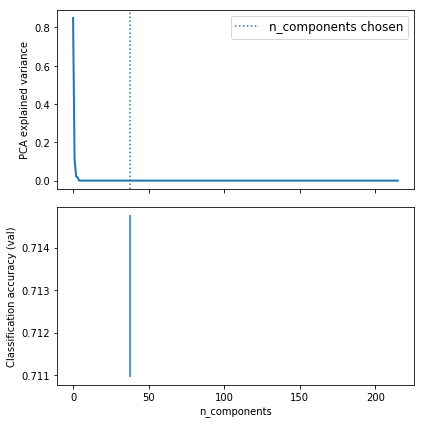

CPU times: user 1min 24s, sys: 2.59 s, total: 1min 27s
Wall time: 47.9 s


In [24]:
%%time



transformer = FunctionTransformer(np.log, validate=True)

scl = StandardScaler()

logistic = SGDClassifier(loss='modified_huber', max_iter=10000, tol=np.exp(-5), random_state=0)

pca = PCA()
pipe = Pipeline(steps=[('standardize', scl), # ('logarithm', transformer), 
                       ('pca', pca), ('logistic', logistic)])

# After having run a larger search: 
'''Best Parameter (CV score=0.765):
{'logistic__alpha': 0.15848931924611143, 'logistic__loss': 'modified_huber', 'logistic__penalty': 'l2', 'pca__n_components': 218}
CPU times: user 44min 51s, sys: 1min 46s, total: 46min 37s
Wall time: 23min 30s

'''
best = {'logistic__alpha': 0.15848931924611143, 'logistic__loss': 'log', 'logistic__penalty': 'l2',
       'pca__n_components': 38}
# param_grid = {
#     'pca__n_components': np.arange(b,NCm, a**b),
#     'logistic__alpha': np.logspace(-b**b, b**b, a),
#     'logistic__loss': ['modified_huber', 'log'], 
#     'logistic__penalty': ['l2', 'l1']
#}
param_grid = {
    'pca__n_components': [best['pca__n_components']],
    'logistic__alpha': [best['logistic__alpha']],
    'logistic__loss': [best['logistic__loss']],
    'logistic__penalty':[best['logistic__penalty']]
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=5, scoring='recall_micro', return_train_score=False)
#search = GridSearchCV(pipe, param_grid, cv=5, scoring='recall')
search.fit(X, y)

print('Best Parameter (CV score=%0.5f):' % search.best_score_)
print(search.best_params_)

#Plot the PCA spectrum
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

print(pca.explained_variance_ratio_)


ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()

In [25]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__alpha,param_logistic__loss,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.339179,0.132803,0.174691,0.007847,0.158489,log,l2,38,"{'logistic__alpha': 0.15848931924611143, 'logi...",0.712061,0.709873,0.712542,0.714646,0.715188,0.712862,0.001912,1


In [26]:
# pipe = Pipeline(steps=[('standardize', scl),
#                        ('pca', PCA(n_components=38)), 
#                        ('logistic', 
#     SGDClassifier(loss='log', max_iter=10000, tol=np.exp(-5), random_state=0, alpha = 0.15848931924611143,
#                   penalty='l2'))])

In [27]:
test_url = "unit-3/test_features.csv"
df = pd.read_csv(test_url, parse_dates=['date_recorded'],index_col='id' )
df['timestamp'] = df.date_recorded.apply(lambda d: d.timestamp()/ 10 ** 9)
df_ = df.drop('date_recorded', inplace = False, axis=1)
df_[dc] = ['fuctional'] * df_.shape[0]
df_.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,timestamp,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,1.359936,fuctional
51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,1.359936,fuctional
17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,1.359677,fuctional
45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,1.358813,fuctional
49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1.364342,fuctional


In [28]:
df_.shape

(14358, 40)

In [29]:
dfd_ = encoders.transform(df_)
dfdf_ = dfd_.drop(drop, axis=1)

In [30]:
# dfdf_[dc] = ['functional'] * dfdf_.shape[0]
dfdf_.head()

,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,public_meeting_True,public_meeting_nan,public_meeting_False,recorded_by_GeoData Consultants Ltd,permit_False,permit_True,permit_nan,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown,payment_pay annually,payment_never pay,payment_pay per bucket,payment_unknown,payment_pay when scheme fails,payment_other,payment_pay monthly,payment_type_annually,payment_type_never pay,payment_type_per bucket,payment_type_unknown,payment_type_on failure,payment_type_other,payment_type_monthly,water_quality_soft,water_quality_salty,water_quality_milky,water_quality_unknown,water_quality_fluoride,water_quality_coloured,water_quality_salty abandoned,water_quality_fluoride abandoned,quality_group_good,quality_group_salty,quality_group_milky,quality_group_unknown,quality_group_fluoride,quality_group_colored,quantity_enough,quantity_insufficient,quantity_dry,quantity_seasonal,quantity_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_dry,quantity_group_seasonal,quantity_group_unknown,source_spring,source_rainwater harvesting,source_dam,source_machine dbh,source_other,source_shallow well,source_river,source_hand dtw,source_lake,source_unknown,source_type_spring,source_type_rainwater harvesting,source_type_dam,source_type_borehole,source_type_other,source_type_shallow well,source_type_river/lake,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_other,waterpoint_type_improved spring,waterpoint_type_cattle trough,waterpoint_type_dam,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_other,waterpoint_type_group_improved spring,waterpoint_type_group_cattle trough,waterpoint_type_group_dam,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,funder_10,funder_11,installer_1,installer_2,installer_3,installer_4,installer_5,installer_6,installer_7,installer_8,installer_9,installer_10,installer_11,installer_12,wpt_name_1,wpt_name_2,wpt_name_3,wpt_name_4,wpt_name_5,wpt_name_6,wpt_name_7,wpt_name_8,wpt_name_9,wpt_name_10,wpt_name_11,wpt_name_12,wpt_name_13,wpt_name_14,wpt_name_15,wpt_name_16,subvillage_1,subvillage_2,subvillage_3,subvillage_4,subvillage_5,subvillage_6,subvillage_7,subvillage_8,subvillage_9,subvillage_10,subvillage_11,subvillage_12,subvillage_13,subvillage_14,subvillage_15,region_1,region_2,region_3,region_4,region_5,lga_1,lga_2,lga_3,lga_4,lga_5,lga_6,lga_7,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8,ward_9,ward_10,ward_11,ward_12,scheme_management_1,scheme_management_2,scheme_management_3,scheme_management_4,scheme_name_1,scheme_name_2,scheme_name_3,scheme_name_4,scheme_name_5,scheme_name_6,scheme_name_7,scheme_name_8,scheme_name_9,scheme_name_10,scheme_name_11,scheme_name_12,extraction_type_1,extraction_type_2,extraction_type_3,extraction_type_4,extraction_type_5,extraction_type_group_1,extraction_type_group_2,extraction_type_group_3,extraction_type_group_4,management_1,management_2,management_3,management_4,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,timestamp,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,

In [31]:
dfdf_.shape

(14358, 217)

In [32]:
dfp = dfdf_.drop(dc, axis=1)

In [33]:
dfp.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [34]:
dfy = search.best_estimator_.predict(dfp)

In [35]:
dfy.shape

(14358,)

In [36]:
with open('test.csv', 'w') as f:
    f.write('id,status_group\n')
    for fu,i in zip(dfy, dfp.index):
        f.write(f"{i},{fu}")
        f.write('\n')


In [51]:
# read in data

df_y = pd.DataFrame(y)
print(df_y[df_y.status_group == 'functional needs repair'].shape)
print(df_y[df_y.status_group == 'functional'].shape)
print(df_y[df_y.status_group == 'non functional'].shape)
# df_y.head(40)
# print(dc)
# dfh_y = ce.OneHotEncoder(use_cat_names=True,cols=[dc]).fit_transform(df_y)
# dfh_y.head()
dtrain = xgb.DMatrix(X, label=[1 if s == 'functional needs repair' else (2 if s == 'functional' else 3) 
                              for s in df_y[dc].values])
# dfh_y[dfh_y['status_group_-1'] == 1].shape 
# dfh_y_ = dfh_y.drop('status_group_-1', axis=1)
# dtest = xgb.DMatrix(dfh_y_)

# specify parameters via map
# param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'reg:linear' }
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 6
num_round = 5
# dfh_y_.head(40)
bst = xgb.train(param, dtrain, num_round)
# make prediction
# dfp.feature_names = list(dfp.columns)
test = xgb.DMatrix(dfp)
# dfp.handle = id(dfp)
preds = bst.predict(test)
#dfp.shape, X.shape

(4317, 1)
(32259, 1)
(22824, 1)


In [41]:
?preds

In [42]:
preds[0]

2.915041

In [43]:
len(preds)

14358

In [44]:
dfp.shape

(14358, 216)

In [53]:
with open('testxgb.csv', 'w') as f:
    f.write('id,status_group\n')
    for fu,i in zip(preds, dfp.index):
        index = round(fu)
        d = 'non functional' if index == 3 else ('functional' if index == 2 else 'functional needs repair')
        f.write(f"{i},{d}")
        f.write('\n')